# Add Folders to Path

In [1]:
%%time
import sys, os
# get current directory
path = os.getcwd()
# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-2])
# add Algorithm folder to current working path in order to access the functions inside the folder ´Algorithms´
sys.path.append(parent_directory+"/Src")

Wall time: 0 ns


# Import Data

In [2]:
%%time
import scipy.io as sio

#Import velocity data from file in data-folder
mat_file = sio.loadmat('../../Data/double_gyre.mat')

U = mat_file['u']
V = mat_file['v']
x = mat_file['x']
y = mat_file['y']
time = mat_file['t']

Wall time: 112 ms


# Data/Parameters for Dynamical System

In [3]:
%%time
import numpy as np

# Number of cores to be used for parallel computing
Ncores = 8

# Incompressible/Compressible flow. {True, False}
Incompressible = True

# Periodic boundary conditions
periodic_x = False
periodic_y = False
Periodic = [periodic_x, periodic_y]

## Compute Meshgrid
X, Y = np.meshgrid(x, y)

# List of parameters of the flow.
params_data = {"X": X, "Y": Y, "Time": time, "U": U, "V": V, "Ncores": Ncores, "Periodic": Periodic}

Wall time: 997 µs


<a id='Spatio-Temporal-Domain-of-Dynamical-System'></a>
# Spatio-Temporal Domain of Dynamical System

In [4]:
%%time
# Initial time (in days)
t0 = 0

# Final time (in days)
tN = 10

# time step-size
dt = .1

# time array
time = np.arange(t0, tN+dt, dt)

# longitudinal and latitudinal boundaries (in degrees)
xmin = 0
xmax = 2
ymin = 0
ymax = 1

# spacing of meshgrid (in degrees)
dx = 0.005
dy = 0.005

# x/y arrays for domain
x_domain = np.arange(xmin, xmax + dx, dx)
y_domain = np.arange(ymin, ymax + dy, dy)

# domain meshgrid
X_domain, Y_domain = np.meshgrid(x_domain, y_domain)

# list of parameters
params_DS = {"time": time, "X_domain": X_domain, "Y_domain": Y_domain}

# Initialize Dynamical System
from ipynb.fs.defs.DynamicalSystem import *
DS = Dynamical_System(params_data, params_DS)

Wall time: 301 ms


# Interpolate Velocity

In order to evaluate the velocity field at arbitrary locations and times, we must interpolate the discrete velocity data. The interpolation with respect to time is always linear. The interpolation with respect to space can be chosen to be "cubic" or "linear". In order to favour a smooth velocity field, we interpolate the velocity field in space using a cubic interpolant.

In [5]:
%%time
# Interpolate velocity data using cubic spatial interpolation
DS._Interpolation_velocity("cubic")

Wall time: 17 ms


# Cauchy Green strain tensor over meshgrid of initial conditions

Next, we compute the Cauchy Green strain tensor for all the initial conditions defined on the meshgrid ('X_domain', 'Y_domain') over the time-interval 'time'. We thereby first calculate the gradient of the flow map using an auxiliary grid. 'aux_grid' specifies the ratio between the auxiliary grid and the original meshgrid. This parameter is generally chosen to be between $ [\dfrac{1}{20}, \dfrac{1}{100}] $. The computations are parallelized.

In [6]:
%%time
# Import function to calculate Cauchy Green (CG) strain tensor from gradient of Flow map
from ipynb.fs.defs.CauchyGreen import _CauchyGreen

# tqdm is used to display progress bar
from tqdm.notebook import tqdm

# joblib is used for parallel computing
from joblib import Parallel, delayed

# Define ratio of auxiliary grid vs original meshgrid
aux_grid = 0.1

def parallel(i):
    
    # Define CG tensor
    C_ = np.zeros((X_domain.shape[1], 2, 2))
    
    # Iterate over initial conditions
    for j in range(X_domain.shape[1]):
        
        # Point at which to calculate CG tensor
        x = np.array([X_domain[i, j], Y_domain[i, j]])
        
        # Calculate gradient of flow map at 'x' over the time-interval 'time' using an auxiliary grid ratio 'aux_grid'
        grad_Fmap = DS._grad_Fmap(x, time, aux_grid)
        
        C_[j, :, :] = _CauchyGreen(grad_Fmap)
        
    return C_

C = np.array(Parallel(n_jobs=Ncores, verbose = 0)(delayed(parallel)(i) for i in tqdm(range(X_domain.shape[0]))))

  0%|          | 0/201 [00:00<?, ?it/s]

Wall time: 8min 1s


# Compute Tensorfield Properties

We now proceed by computing the properties of the Cauchy Green strain tensor 'C' such as the eigenvalues 'lambda1', 'lambda2' and eigenvectors 'eigenv1', 'eigenv2'. Furthermore, we also need the spatial derivatives of the elements of 'C'.

In [7]:
# Function which computes tensorfield properties
from ipynb.fs.defs.tensorfield import _tensorfield

# Compute tensorfield properties
lambda1, lambda2, eigenv1, eigenv2, C11, C12, C22, C11x, C11y, C12x, C12y, C22x, C22y = _tensorfield(X_domain, Y_domain, C, aux_grid, type = 'LCS')

ipynb.fs.defs.eigen:63: RuntimeWarning: invalid value encountered in true_divide
ipynb.fs.defs.eigen:66: RuntimeWarning: invalid value encountered in true_divide


# Interpolate $ \dot{\phi}(x, y, \phi)$ 

In [8]:
%%time
# Function which computes the interpolant of \dot{\phi}
from ipynb.fs.defs.phi_prime import _phi_prime

# Interpolant phi_phrime
interp_phi_prime, interp_DOE = _phi_prime(X_domain, Y_domain, C11, C12, C22, C11x, C11y, C12x, C12y, C22x, C22y)

Wall time: 1.36 s


# Find closed null-geodesics of $ C_{t_0}^{t} − \lambda^2 I $

Elliptic OECSs are closed null geodesics of the one-parameter family of Lorentzian metrics $ C_{t_0}^{t} − \lambda^2 I, \lambda \in \mathbb{R}$

In [9]:
%%time
# function which computes closed null geodesics
from ipynb.fs.defs.closed_null_geodesics import _closed_null_geodesics
# function which computes outermost closed null geodesics
from ipynb.fs.defs.outermost_elliptic_LCS import _outermost_elliptic_LCS

# define lambda range
lambda_min = 0.99
lambda_max = 1.01
n_lambda = 3
lambda_range = np.linspace(lambda_min, lambda_max, n_lambda)

# define threshold distance for periodicity of trajectory
d_threshold = dx/2

# parameter specifying sparsity of initial conditions.
# If sparse_ic = 1, then original meshgrid is used for computation of initial level sets.
# Increasing this parameter reduces the number of initial conditions and thereby reduces the computational time involved.
sparse_ic = 1

elliptic_LCS = []

for lam in lambda_range:
    
    print("Compute elliptic LCS for lambda:", lam)
    
    # Define list storing x, y coordinates of elliptic OECS
    x_elliptic, y_elliptic = [], []
    
    # Find all closed null geodesics
    closed_null_geodesics = _closed_null_geodesics(X_domain, Y_domain, lam, interp_phi_prime, d_threshold, C11, interp_DOE, sparse_ic, Ncores)  
        
    # Extract outermost closed null geodesics
    outermost_elliptic_LCS = _outermost_elliptic_LCS(closed_null_geodesics)
    
    # Store outermost closed null geodesics in list (so that it can be accessed more easily for plotting)
    if outermost_elliptic_LCS:
        
        for elliptic in outermost_elliptic_LCS:
            
            x_elliptic.append(elliptic[0])
            y_elliptic.append(elliptic[1])
            
    elliptic_LCS.append([x_elliptic, y_elliptic])

Compute elliptic LCS for lambda = 0.98


  0%|          | 0/1454 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Compute elliptic LCS for lambda = 0.99


  0%|          | 0/1447 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Compute elliptic LCS for lambda = 1.0


  0%|          | 0/1456 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Compute elliptic LCS for lambda = 1.01


  0%|          | 0/1456 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Compute elliptic LCS for lambda = 1.02


  0%|          | 0/1423 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Compute elliptic LCS for lambda = 1.03


  0%|          | 0/1443 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Wall time: 1h 24min 38s


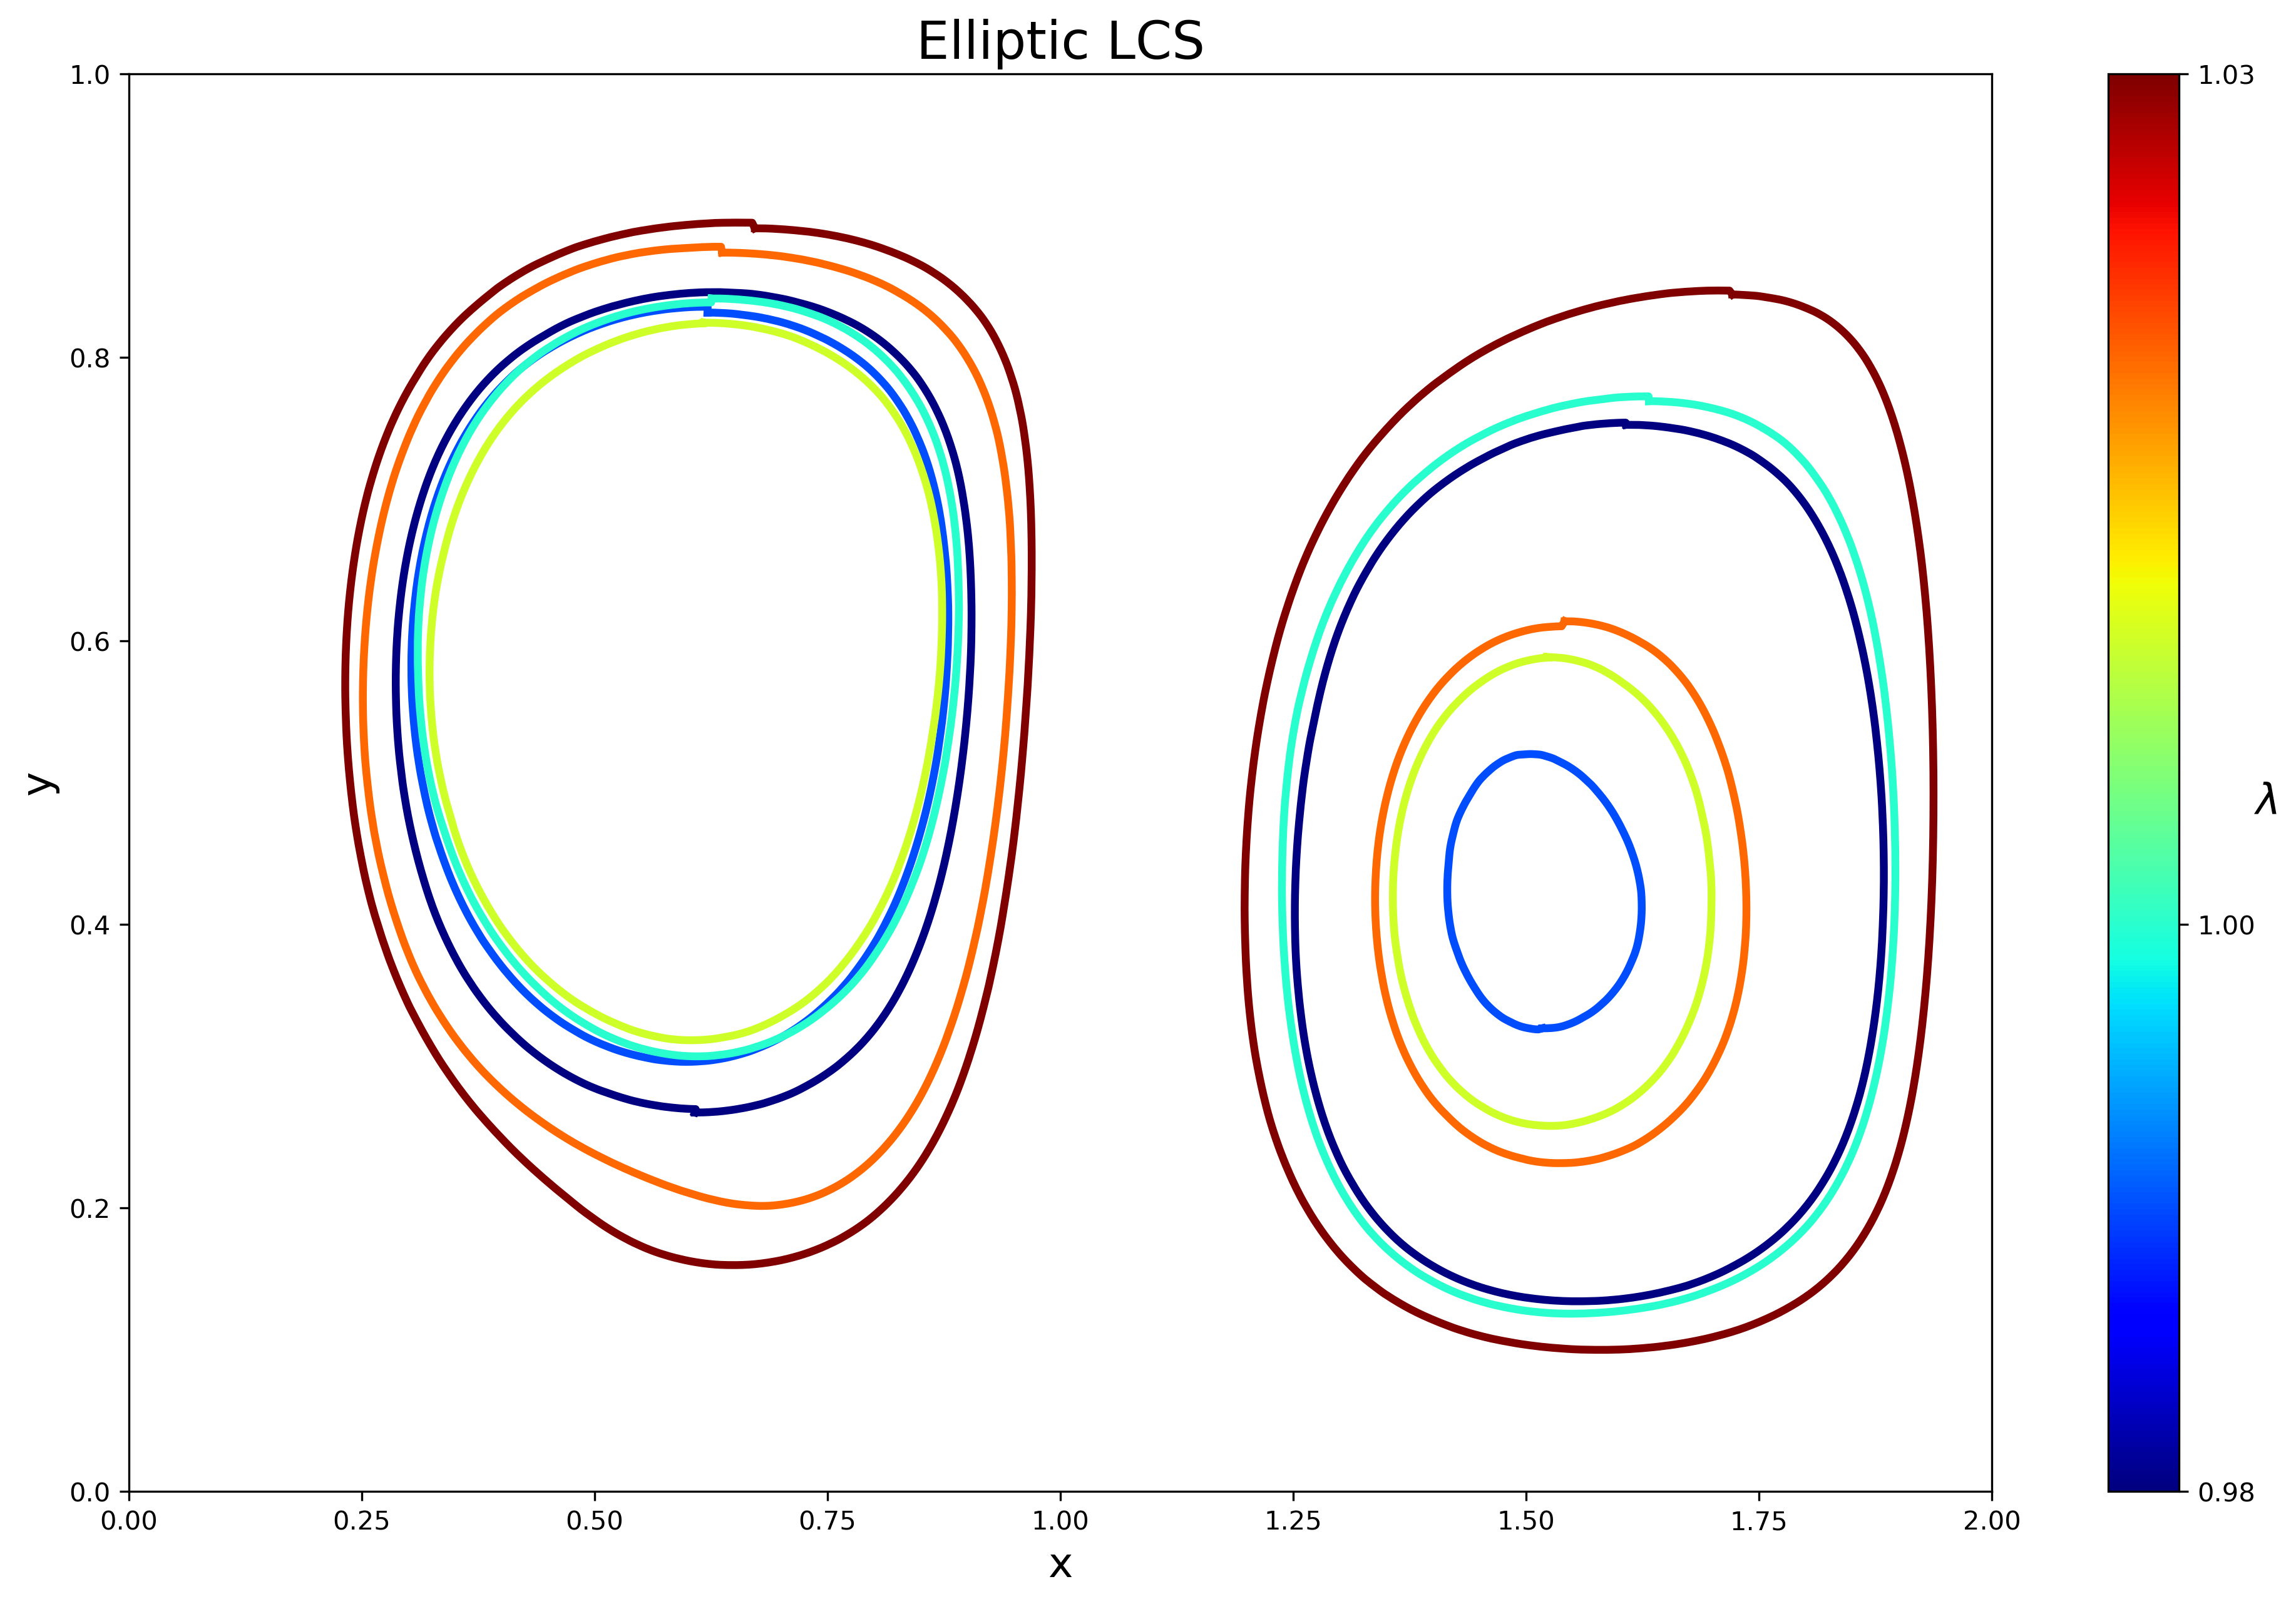

Wall time: 919 ms


In [10]:
%%time
######################################## Plot elliptic LCS ########################################

# import plotting library
import matplotlib.pyplot as plt
import matplotlib as mpl

# Define figure/axes
fig = plt.figure(figsize = (16, 10), dpi = 300)
ax = plt.axes()

# Define norm/cmap
norm = mpl.colors.Normalize(vmin=lambda_min, vmax=lambda_max)
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.jet)

# Iterate over all elliptic LCS 
for i in range(len(elliptic_LCS)):
    
    for j in range(len(elliptic_LCS[i][0])):
        
        if elliptic_LCS[i][0][j] is not None:
        
            ax.plot(elliptic_LCS[i][0][j], elliptic_LCS[i][1][j], c=cmap.to_rgba(lambda_range[i]), linewidth = 3)

# Set axis limits
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])

# Set axis labels
ax.set_xlabel("x", fontsize = 16)
ax.set_ylabel("y", fontsize = 16)

# Colorbar
cbar = fig.colorbar(cmap, ticks=[lambda_range.min(), 1, lambda_range.max()])
cbar.ax.set_ylabel(r'$ \lambda $', rotation = 0, fontsize = 16)

# Title
ax.set_title("Elliptic LCS", fontsize = 20)
plt.show();